# **Term Deposit Marketing**

**Background:**

This project is for a small startup focusing mainly on providing machine learning solutions in the European banking market. They work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

They are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, they are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal, they are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

## **Importing Python packages and data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import matplotlib.ticker as mtick
import matplotlib.style as style
import seaborn as sns
import scipy
from scipy.stats import randint, loguniform
from statistics import mean
import collections
from collections import Counter
import warnings
from google.colab import files
import time
style.use('ggplot')
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
!pip install category_encoders
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

In [2]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving term-deposit-marketing-2020.csv to term-deposit-marketing-2020.csv


In [2]:
# Now, we can read the .csv file from desktop
df = pd.read_csv('term-deposit-marketing-2020.csv')

##**Exploratory Data Analysis**

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [5]:
df.isnull().values.any()

False

Great, looks like there are no missing values.

In [6]:
df.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


The balance variable is quite skewed and has a large variance as seen below. We will take a closer look at these distributions later. This data should be scaled before modeling unless gradient boosting is employed.

In [7]:
df.var()

age             92.96
balance    8431878.56
day             68.53
duration     67270.98
campaign        10.49
dtype: float64

In [8]:
print(df.groupby(['y']).size() / df.shape[0] * 100)

y
no    92.76
yes    7.24
dtype: float64


We have a very unbalanced data set.  Only about 7% of customers have subscribed to a term deposit in this data set.  We will have to make sure that we stratify this data before modeling and we use the appropriate methods for this.  This will ensure a test set of approximately the same percentage.

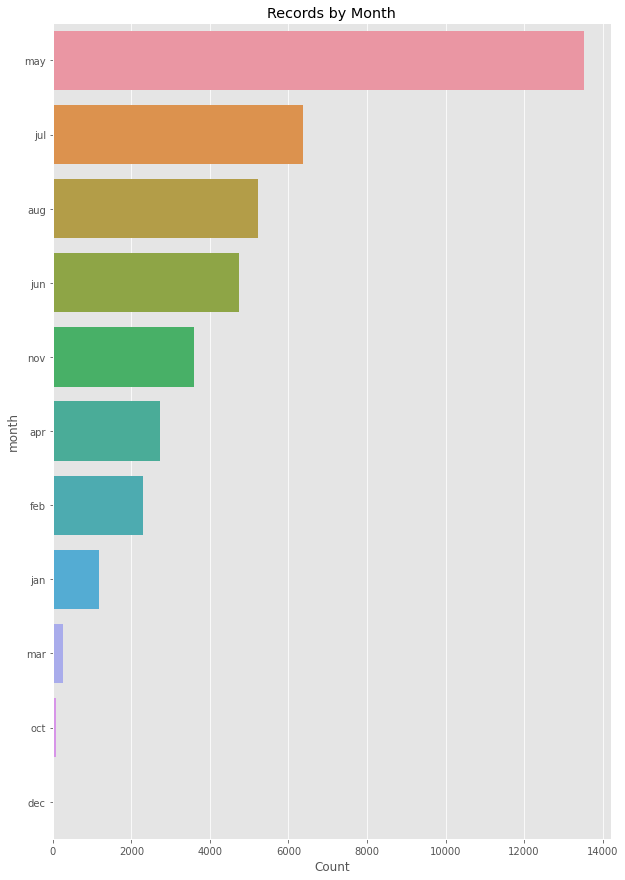

In [9]:
plt.figure(figsize=(10,15))

sns.countplot(y = 'month', data = df, order=df.month.value_counts().index)
plt.title('Records by Month')
plt.xlabel('Count')

plt.show()

This distribution plot of the month field is not what I expected at all.  Very little observations in March, October, December and none in September.  Now, three of these months are at the end of a quarter but so is June, which has a substantial amount of observations.  I suspect that this would skew results and provide little insight, so we will drop this variable from the data set.  

In [10]:
df = df.drop(['month'], axis = 1)

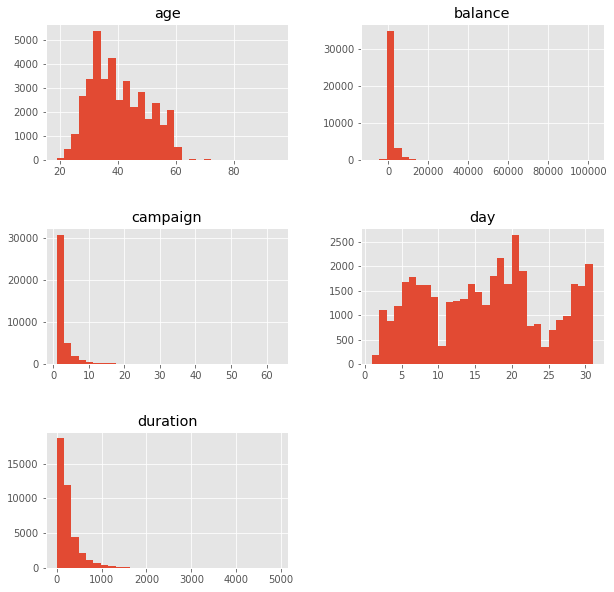

In [11]:
df.hist(figsize=(10,10), bins = 30)
plt.subplots_adjust(hspace=0.5);

These distributions are interesting as balance, duration and campaign are skewed to the right.  Day and age are interesting as age is almost symmetric centering around 35 years of age and day fluctuates throught the month. There is one thing that is peculiar about the day as we look at the values for it below.  There is no particular trend.  For instance, the 30th has the most conversions but the 31st has the least. Additionally, there are days in the middle of the month that have high conversion and days in the middle of the month that have low conversions.  This may be coincidental.

In [12]:
dayTrend = df[df['y'] == 'yes']
dayTrend.day.value_counts()

30    224
18    165
20    153
21    139
15    123
13    117
4     117
14    115
17    115
5     113
6     110
2     104
12    104
8     102
16     96
11     85
27     84
7      80
22     80
3      80
19     73
9      72
25     72
28     61
26     61
23     59
29     49
10     45
1      40
24     32
31     26
Name: day, dtype: int64

Also, the duration variable cannot be used for a couple of reasons.  Longer calls may be an indicator of a transaction being completed which introduces bias.  Customers may already be interested in purchasing a term deposit resulting in longer call duration. The day variable and the duration variable should be dropped from the data set.

In [13]:
df = df.drop(['day', 'duration'], axis = 1)

In [14]:
print(df.nunique())

age            70
job            12
marital         3
education       4
default         2
balance      6849
housing         2
loan            2
contact         3
campaign       48
y               2
dtype: int64


Unique values for variables help identify categorical, binary and continuous variables. The only strange one is the job variable but this makes sense. Below,we will check the distribution of seemingly categorical variables and check for unknown values.

In [15]:
df.job.value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [16]:
df.marital.value_counts()

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

In [17]:
df.education.value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

We have a very small amount of 'unknown' values for job and education variables.  Comparatively, we can remove these unknowns if it is less than 5% of the data set, which is standard.

In [18]:
df.contact.value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

In [19]:
#Removing 'unknown' values from the data set.
contacts = df[df['contact'] == 'unknown']

print(contacts.groupby(['y']).size() / contacts.shape[0] * 100)

y
no    96.11
yes    3.89
dtype: float64


The contact field is strange as we are only differentiating between cellular and hose phones and the number for house phones is small.  Moreover, there are over 12,000 unknown entries.  This variable should be deleted from the data set as I do not suspect that it will provide much insight and if it does, it calls for a new experiment and survey. 

In [20]:
df = df.drop(['contact'], axis = 1)

In [21]:
#Removing 'unknown' values from the data set.
df = df[df['education'] != 'unknown']

In [22]:
df.job.value_counts()

blue-collar      8944
management       7977
technician       6638
admin            4335
services         3775
self-employed    1383
retired          1378
entrepreneur     1331
unemployed       1080
housemaid        1047
student           450
unknown           131
Name: job, dtype: int64

It looks like there are still some unknowns in the job variable as we did not catach all of them by removing unknowns from the education variable.  This means that we will remove 1662 rows from the data set of 40000 which is about 4 percent.  Because this is below 5%, this would be good practice and may help the predictive power of these features.

In [23]:
df = df[df['job'] != 'unknown']

In [24]:
print(df.nunique())

age            70
job            11
marital         3
education       3
default         2
balance      6685
housing         2
loan            2
campaign       47
y               2
dtype: int64


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38338 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        38338 non-null  int64 
 1   job        38338 non-null  object
 2   marital    38338 non-null  object
 3   education  38338 non-null  object
 4   default    38338 non-null  object
 5   balance    38338 non-null  int64 
 6   housing    38338 non-null  object
 7   loan       38338 non-null  object
 8   campaign   38338 non-null  int64 
 9   y          38338 non-null  object
dtypes: int64(3), object(7)
memory usage: 3.2+ MB


That is more like it.  Time to wrangle some data.

##**Data Wrangling**

We will now convert the binary variables to integers, namely the target y.

In [26]:
df['default'] = df['default'].replace({'no':0, 'yes':1})
df['housing'] = df['housing'].replace({'no':0, 'yes':1})
df['loan'] = df['loan'].replace({'no':0, 'yes':1})
df['y'] = df['y'].replace({'no':0, 'yes':1})

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38338 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        38338 non-null  int64 
 1   job        38338 non-null  object
 2   marital    38338 non-null  object
 3   education  38338 non-null  object
 4   default    38338 non-null  int64 
 5   balance    38338 non-null  int64 
 6   housing    38338 non-null  int64 
 7   loan       38338 non-null  int64 
 8   campaign   38338 non-null  int64 
 9   y          38338 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 3.2+ MB


After converting binary variables to integers, there are only three variables that need converted for modeling purposes.  I will use the TargetEncoder here as there are now 11 values for the job feature and this encoder is very efficient.  Using One-Hot encoding or even feature hashing would create way too many features.  I will use One-Hot encoding for the marital and education features since there are only three values for those features.  The original features will be deleted, subsequently.

In [28]:
ce = TargetEncoder()
df['jobLabel'] = ce.fit_transform(df['job'], df['y'])

In [29]:
# One-Hot encoding with get_dummies
df = pd.get_dummies(df, columns = ['marital', 'education'])

In [30]:
df.head()

,age,job,default,balance,housing,loan,campaign,y,jobLabel,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,management,0,2143,1,0,1,0,0.08,0,1,0,0,0,1
1,44,technician,0,29,1,0,1,0,0.07,0,0,1,0,1,0
2,33,entrepreneur,0,2,1,1,1,0,0.06,0,1,0,0,1,0
5,35,management,0,231,1,0,1,0,0.08,0,1,0,0,0,1
6,28,management,0,447,1,1,1,0,0.08,0,0,1,0,0,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38338 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38338 non-null  int64  
 1   job                  38338 non-null  object 
 2   default              38338 non-null  int64  
 3   balance              38338 non-null  int64  
 4   housing              38338 non-null  int64  
 5   loan                 38338 non-null  int64  
 6   campaign             38338 non-null  int64  
 7   y                    38338 non-null  int64  
 8   jobLabel             38338 non-null  float64
 9   marital_divorced     38338 non-null  uint8  
 10  marital_married      38338 non-null  uint8  
 11  marital_single       38338 non-null  uint8  
 12  education_primary    38338 non-null  uint8  
 13  education_secondary  38338 non-null  uint8  
 14  education_tertiary   38338 non-null  uint8  
dtypes: float64(1), int64(7), object(1), 

Now, we will define our target (y), drop the remaining object features, define X and scale the values to get ready for modeling.

In [32]:
y = df['y']

df = df.drop(['job', 'y'], axis = 1)

In [33]:
columns = df.columns
columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'jobLabel',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary'],
      dtype='object')

These columns should match the preceding dataframe.

In [34]:
df.head()

,age,default,balance,housing,loan,campaign,jobLabel,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,1,0.08,0,1,0,0,0,1
1,44,0,29,1,0,1,0.07,0,0,1,0,1,0
2,33,0,2,1,1,1,0.06,0,1,0,0,1,0
5,35,0,231,1,0,1,0.08,0,1,0,0,0,1
6,28,0,447,1,1,1,0.08,0,0,1,0,0,1


I want to change the name of some of the columns to be more readable.

In [35]:
df.columns = ['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'jobLabel', 'divorced', 'married', 'single', 'education_primary', 'education_secondary', 'education_tertiary']

In [36]:
df.head()

,age,default,balance,housing,loan,campaign,jobLabel,divorced,married,single,education_primary,education_secondary,education_tertiary
0,58,0,2143,1,0,1,0.08,0,1,0,0,0,1
1,44,0,29,1,0,1,0.07,0,0,1,0,1,0
2,33,0,2,1,1,1,0.06,0,1,0,0,1,0
5,35,0,231,1,0,1,0.08,0,1,0,0,0,1
6,28,0,447,1,1,1,0.08,0,0,1,0,0,1


Now, we are ready for modeling.

##**Modeling**

In [37]:
X = df

seed = 2346

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)
print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])

0.7499869581094476
0.25001304189055246


Good, the training and test sets are in the percentages we want them.  I always like to check that.

In [38]:
clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', class_weight='balanced')
modelT = clf.fit(X_train, y_train)
pred_y = modelT.predict(X_test)

test_precision = round(precision_score(y_test, pred_y), 4)
test_recall = round(recall_score(y_test, pred_y), 4)

print("Training accuracy: ", round(clf.score(X_train, y_train), 4))
print("Test accuracy: ", round(accuracy_score(y_test, pred_y), 4))
print('Test precision: {}, Test recall: {}'.format(test_precision, test_recall))

Training accuracy:  0.6647
Test accuracy:  0.6561
Test precision: 0.1015, Test recall: 0.4742


That accuracy looks pretty bad but this is only one tree, so the predictive power of the tree by itself is poor.  The precision and recall numbers are also very low.  We will need to either oversample or undersample the data in some way.  Let's optimize the tree to see what a good depth would be and see what kind of customers would be most likely to purchase a term deposit as a form of EDA.

In [39]:
depth_list = list(range(2, 15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list
for index in range(len(depth_list)):
    clf = DecisionTreeClassifier(max_depth=depth_list[index], class_weight='balanced', criterion = 'gini')
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    depth_tuning[index,1] = accuracy_score(y_test, pred_y)
    depth_tuning[index,2] = precision_score(y_test, pred_y)
    depth_tuning[index,3] = recall_score(y_test, pred_y)
col_names = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max_Depth  Accuracy  Precision  Recall
0        2.00      0.60       0.09    0.52
1        3.00      0.77       0.12    0.33
2        4.00      0.59       0.10    0.55
3        5.00      0.63       0.10    0.50
4        6.00      0.65       0.10    0.48
5        7.00      0.66       0.10    0.48
6        8.00      0.61       0.10    0.53
7        9.00      0.62       0.10    0.52
8       10.00      0.67       0.11    0.47
9       11.00      0.63       0.10    0.51
10      12.00      0.69       0.11    0.45
11      13.00      0.68       0.10    0.43
12      14.00      0.72       0.11    0.38


We can see that a depth of 3 would be best but the accuracy does not change much.  Let's try a tree depth of 3 for visual appeal. Next, we will determine which features the decision tree finds to be most influential and plot the tree.

[Text(697.5, 951.3000000000001, 'marital_married <= 0.5\ngini = 0.5\nsamples = 28753\nvalue = [14376.5, 14376.5]'),
 Text(348.75, 679.5, 'balance <= 648.5\ngini = 0.492\nsamples = 11252\nvalue = [5512.457, 7071.535]'),
 Text(174.375, 407.70000000000005, 'age <= 29.5\ngini = 0.499\nsamples = 6990\nvalue = [3478.316, 3707.407]'),
 Text(87.1875, 135.89999999999998, 'gini = 0.479\nsamples = 1411\nvalue = [680.024, 1029.835]'),
 Text(261.5625, 135.89999999999998, 'gini = 0.5\nsamples = 5579\nvalue = [2798.292, 2677.572]'),
 Text(523.125, 407.70000000000005, 'housing <= 0.5\ngini = 0.47\nsamples = 4262\nvalue = [2034.141, 3364.128]'),
 Text(435.9375, 135.89999999999998, 'gini = 0.416\nsamples = 1666\nvalue = [756.601, 1805.644]'),
 Text(610.3125, 135.89999999999998, 'gini = 0.495\nsamples = 2596\nvalue = [1277.54, 1558.484]'),
 Text(1046.25, 679.5, 'age <= 60.5\ngini = 0.495\nsamples = 17501\nvalue = [8864.043, 7304.965]'),
 Text(871.875, 407.70000000000005, 'balance <= 655.5\ngini = 0.493\n

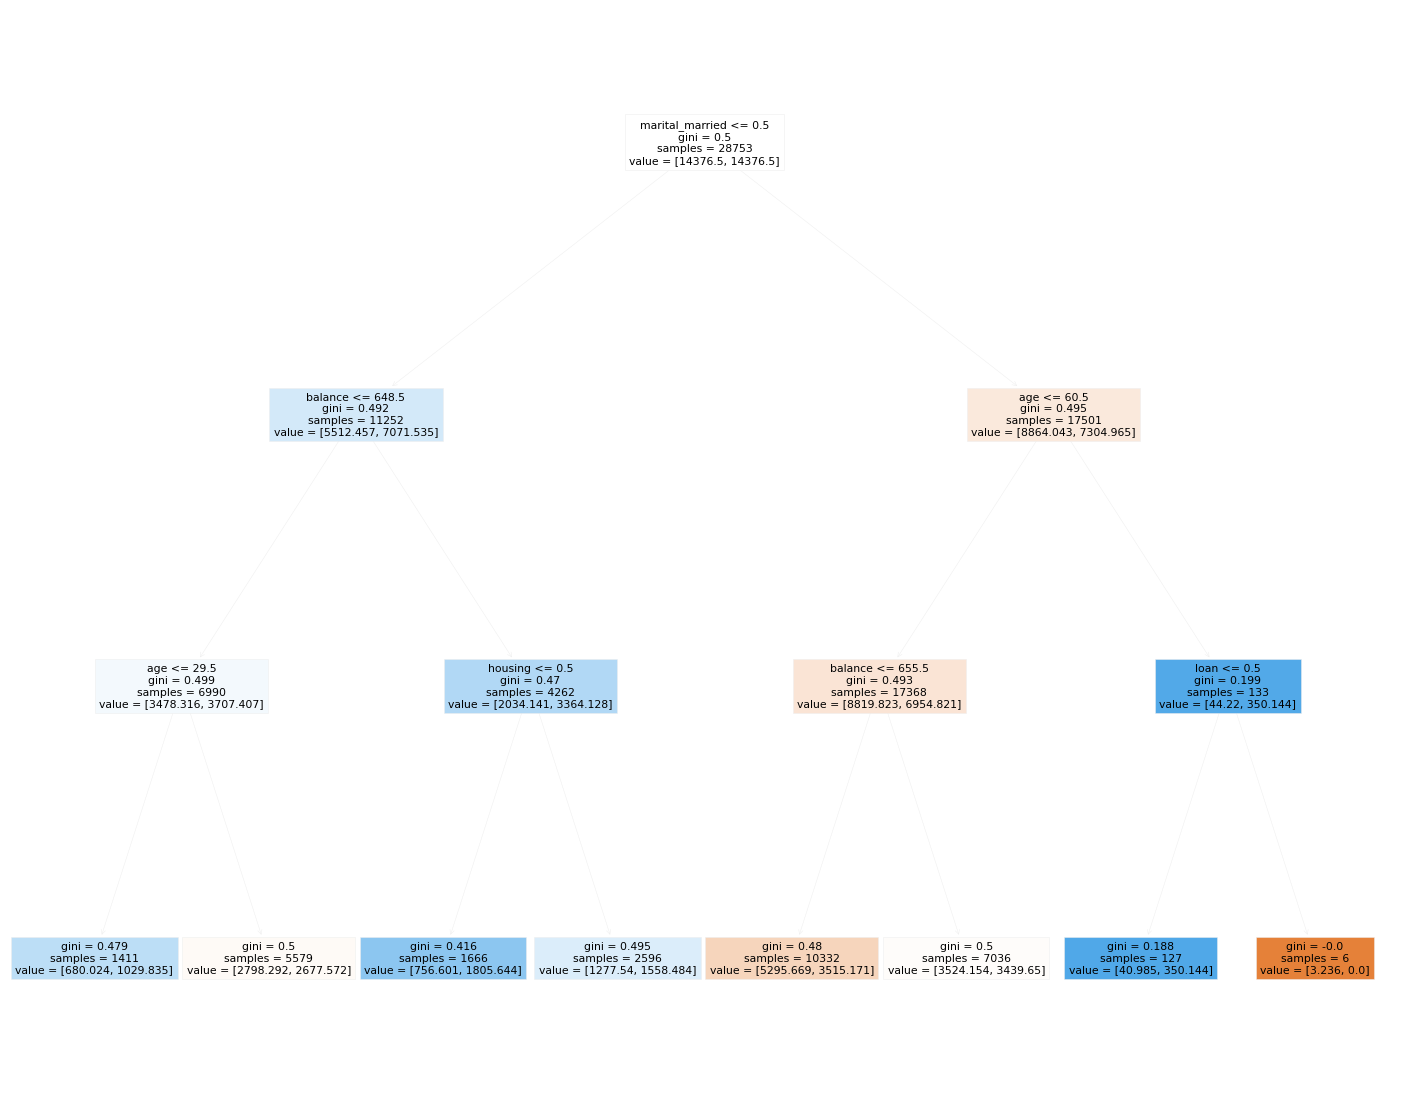

In [40]:
clf = tree.DecisionTreeClassifier(max_depth = 3, criterion = 'gini', class_weight='balanced')
modelT = clf.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names = columns, filled=True)

According to this tree, customers who have a housing loan were more likely to purchase a term deposit.  Married customers with an average yearly balance of over 656 dollars were most likely to purchase a term deposit. Of the customers who have a house, customers who are married were more likely to purchase.  Married customers who were contacted less than 6 times during this campaign were less likely to purchase a term deposit.  As you can imagine, a customer whose average yearly balance is close to $200 or less and does not have a housing loan, they are not a good candidate to purchase.  Odds are slighly better for customers over 60 but not much. Let's see if the Lazy Classifier can help us decide on a machine learning function to use.

In [41]:
lazy = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [02:30<00:00,  5.18s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.59,0.58,0.58,0.69,0.14
ExtraTreeClassifier,0.87,0.53,0.53,0.87,0.06
DecisionTreeClassifier,0.86,0.52,0.52,0.87,0.18
RandomForestClassifier,0.92,0.52,0.52,0.89,2.82
BaggingClassifier,0.92,0.52,0.52,0.89,0.86
GaussianNB,0.92,0.52,0.52,0.89,0.05
ExtraTreesClassifier,0.90,0.51,0.51,0.89,2.33
KNeighborsClassifier,0.92,0.51,0.51,0.89,1.21
QuadraticDiscriminantAnalysis,0.89,0.51,0.51,0.88,0.26


Now, we should conceptually think about what machine learning algorithm to use.  The Balanced Random Forest may be the best choice here as it is tuneable, a good selection for the number of observations under 50,000 and it is good with a large number of features since we have not explored feature elimination yet. It is also good with an unbalanced data set which is certainly what we have here.  Nearest Centroid and Gaussian Naive-Bayes does not have a great deal of hyperparameters, the Extra Tree Classifier can only be used in ensemble methods and the Decision Tree is what we tried earlier and does not have good predictive power as well as being extremely sensitive to changes in the data. Below is my function for hyperparameter tuning that uses randomized search cross-validation.

In [42]:
def hyperparameter_tune(base_model, parameters, n_iter, k, X = X_train, y = y_train):
    start_time = time.time()
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=seed)
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="f1")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_

Now, we will define relevant hyperparameters for the balanced Random Forest.

In [43]:
parameters = {
        
                 'n_estimators': np.arange(100,500),
                 'criterion': ["gini", "entropy"],
                 'max_depth': np.arange(3,20),
                 'min_samples_leaf': randint(1, 9),
                 'min_samples_split': randint(2, 9),
                 'max_features': randint(1, 9)
}

Next, we will fit our Balanced Random Forest on the training set.  Here, we will use the best hyperparameter values after 60 iterations which should put us inside of a 95% confidence interval that we have the best model and to put those hyperparameters into our model subsequently. 

In [44]:
brf = BalancedRandomForestClassifier()

best_params, best_score = hyperparameter_tune(brf, parameters, 60, 5, X_train, y_train)

Elapsed Time: 00:01:02
Cross Val Mean: 0.175, Cross Val Stdev: 0.004
Best Score: 0.624
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 282}


The f1 score was really not a great score but we now have best parameters with 95% confidence.  Now, we should try the optimized model with a different random seed to see how it performs. 

In [45]:
brf_tuned = BalancedRandomForestClassifier(criterion= 'entropy', max_depth = 5, max_features = 8, min_samples_leaf = 8, min_samples_split = 4, n_estimators = 178, random_state = 4444)
brf_tuned.fit(X_train,y_train)
print(brf_tuned.score(X_train,y_train))
print(brf_tuned.score(X_test,y_test))

0.6308559106875804
0.6307772561293689


This is a lower f1 score than we wanted so maybe the Balanced Random Forest model is lowering the error so much that we cannot predict accurately on the positive values.

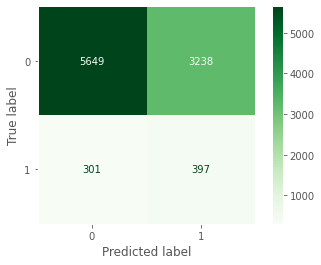

Accuracy of the Balanced Random Forest: 63.07772561293689 

              precision    recall  f1-score   support

           0       0.95      0.64      0.76      8887
           1       0.11      0.57      0.18       698

    accuracy                           0.63      9585
   macro avg       0.53      0.60      0.47      9585
weighted avg       0.89      0.63      0.72      9585



In [46]:
brf_predicted = brf_tuned.predict(X_test)

plot_confusion_matrix(brf_tuned, X_test, y_test, cmap = 'Greens')
plt.grid(False)
plt.show()

brf_acc_score = accuracy_score(y_test, brf_predicted)

print("Accuracy of the Balanced Random Forest:", brf_acc_score * 100,'\n')
print(classification_report(y_test, brf_predicted))

It looks like most of the predicted results have a strong bias for the majority class.  Maybe a different type of tree model or approach would be beneficial.  K-Fold Cross Validation is not suitable for handling imbalanced data because it randomly divides the data into k-folds. Folds might likely have negligible or no data from the minority class resulting in a highly biased model. We can use a repeated stratified k-fold ensuring splitting the data randomly and keeping the same imbalanced class distribution for each subset. SMOTE (Synthetic Minority Oversampling Technique) is one of the oversampling techniques that use a minority class to generate synthetic samples.  SMOTE works by generating instances that are close in feature space, using interpolation between positive cases that are close to each other. It randomly selects a minority class instance and finds its nearest neighbour. Then it creates synthetic models by randomly choosing one of the neighbours and forms a line segment in the feature space. It then generates synthetic instances of the two selected instances as convex combinations.

In [47]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.25, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = BalancedRandomForestClassifier(criterion= 'entropy', max_depth = 5, max_features = 8, min_samples_leaf = 8, min_samples_split = 4, n_estimators = 178, random_state=seed)

In [48]:
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

Mean f1: 0.830
Mean recall: 0.766
Mean precision: 0.907


That is more like it.  Let's take a look at the confusion matrix.  

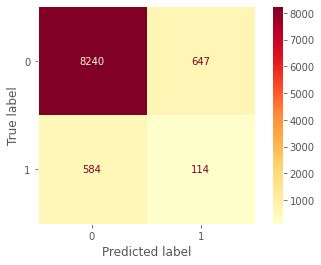

Accuracy of the SMOTE Balanced Random Forest: 87.15701617110068 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8887
           1       0.15      0.16      0.16       698

    accuracy                           0.87      9585
   macro avg       0.54      0.55      0.54      9585
weighted avg       0.88      0.87      0.87      9585



In [49]:
SMOTE_SRF.fit(over_X_train, over_y_train)

#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

plot_confusion_matrix(SMOTE_SRF, X_test, y_test, cmap = 'YlOrRd')
plt.grid(False)
plt.show()

SMOTE_acc_score = accuracy_score(y_test, y_pred)

print("Accuracy of the SMOTE Balanced Random Forest:", SMOTE_acc_score*100,'\n')
print(classification_report(y_test, y_pred))

This result is better but the model is not predicting the customers who are actually purchasing term deposits well. We may have to employ random oversampling which out performs undersampling and turn to XGBoost to control for overfitting.  Overfitting is the main drawback of oversampling as well as increased computation time.  Max depth, gamma, the learning rate, subsample and the max delta step are all parameters that can help control overfitting.

In [50]:
param_grid_xgb = {
                 'max_depth': np.arange(2, 20),
                 'n_estimators': np.arange(100,500),
                 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
                 'subsample': np.arange(0.5, 1.0),
                 'colsample_bytree': np.arange(0.4, 1.0),
                 'colsample_bylevel': np.arange(0.4, 1.0),
                 'min_child_weight': np.arange(1, 10),
                 'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0] 
}

In [51]:
xgb_clf = xgb.XGBClassifier(max_delta_step = 1, verbose = 1, seed=2346)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
rcv = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid_xgb, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
result = rcv.fit(X_train, y_train)
# report the best configuration
print("Best: %f using %s" % (result.best_score_, result.best_params_))
# report all configurations
print(result.cv_results_['mean_test_score'])
print(result.cv_results_['std_test_score'])



[02:25:30] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best: 0.628595 using {'subsample': 0.5, 'reg_lambda': 1.0, 'n_estimators': 426, 'min_child_weight': 8, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}
[0.60859211 0.61259651 0.5        0.59539449 0.62838179 0.61371496
 0.62859532 0.51416675 0.5        0.62154489]
[0.01541071 0.02048596 0.         0.01855024 0.02127647 0.02075517
 0.02028902 0.0056361  0.         0.01960934]


In [52]:
ros = RandomOverSampler(random_state=1111)

# fit predictor and target variable
X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 35546, 1: 2792})
Resample dataset shape Counter({0: 35546, 1: 35546})


The size of the data set has dramatically increased but now have an unbalanced target.  

In [53]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_ros, y_ros, test_size=0.25, random_state=1111)

In [54]:
xgb_ros = xgb.XGBClassifier(objective = 'binary:logistic', seed=1111, gamma = 0.5)

In [55]:
best_params, best_score = hyperparameter_tune(xgb_ros, param_grid_xgb, 60, 5, X_train_o, y_train_o)

Elapsed Time: 00:01:19
Cross Val Mean: 0.885, Cross Val Stdev: 0.002
Best Score: 0.880
Best Parameters: {'subsample': 0.5, 'reg_lambda': 0.1, 'n_estimators': 443, 'min_child_weight': 3, 'max_depth': 16, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}


We will use XGBoost with the best parameters found by my hyperparameter tune function.

In [56]:
xgb_ros_tuned = xgb.XGBClassifier(objective = 'binary:logistic', seed=1111, gamma = 0.5, subsample = 0.5, reg_lambda = 0.1, n_estimators = 443, min_child_weight = 3, max_depth = 16, 
                                  learning_rate = 0.1, colsample_bytree = 0.4, colsample_bylevel = 0.4)
xgb_ros_tuned.fit(X_train_o, y_train_o)
print(xgb_ros_tuned.score(X_train_o, y_train_o))
print(xgb_ros_tuned.score(X_test_o, y_test_o))

0.9292747425870703
0.8923648230461937


This looks good.  The training and test accuracies are similar.  Let's check to see if precision and recall are good.  

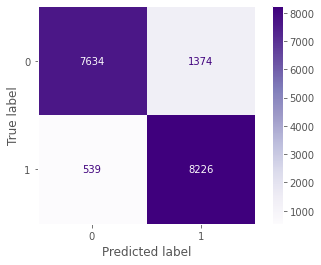

Accuracy of the XGBoost model: 89.23648230461937 

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      9008
           1       0.86      0.94      0.90      8765

    accuracy                           0.89     17773
   macro avg       0.90      0.89      0.89     17773
weighted avg       0.90      0.89      0.89     17773



In [57]:
xgb_ros_tuned_predicted = xgb_ros_tuned.predict(X_test_o)

plot_confusion_matrix(xgb_ros_tuned, X_test_o, y_test_o, cmap = 'Purples')
plt.grid(False)
plt.show()

xgb_acc_score = accuracy_score(y_test_o, xgb_ros_tuned_predicted)

print("Accuracy of the XGBoost model:", xgb_acc_score * 100,'\n')
print(classification_report(y_test_o, xgb_ros_tuned_predicted))

This is what we want and it does not appear that the model has overfit. This model predicts which customers will actually purchase a term deposit.

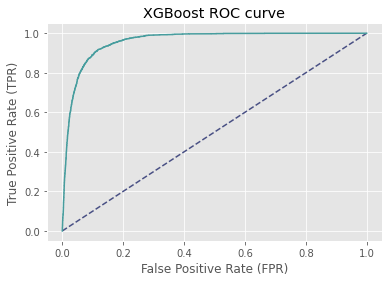

In [58]:
y_pred_proba = xgb_ros_tuned.predict_proba(X_test_o)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_o, y_pred_proba)

plt.plot([0,1],[0,1], color='#495084', linestyle='--')
plt.plot(fpr,tpr, label='ltgb', color='#479D9E')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('XGBoost ROC curve')
plt.show()

In [59]:
roc = roc_auc_score(y_test_o,y_pred_proba)
print('ROC Score: {:.2f}'.format(roc))

ROC Score: 0.96


This is a great score for the area under the ROC curve which now has some validity with a balanced data set.  But, we will take a look at the precision-recall curve anyway below.

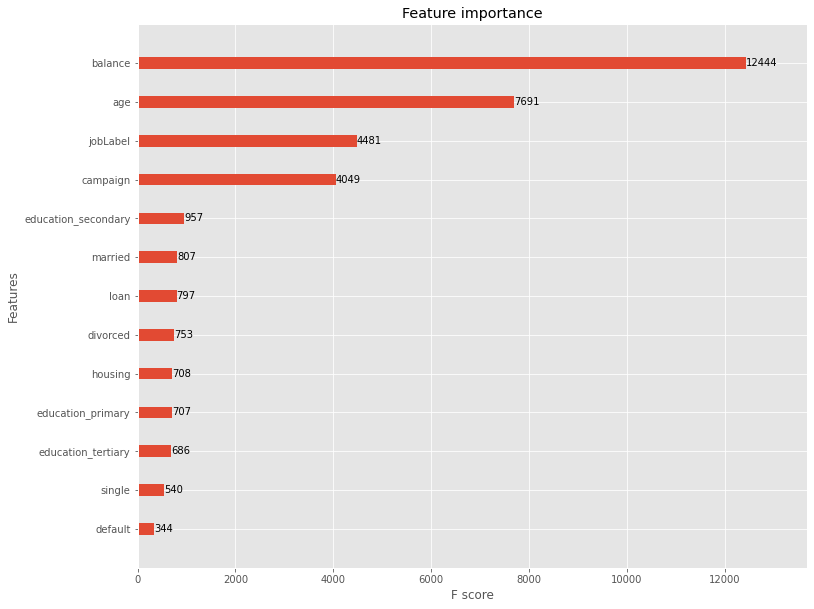

In [60]:
f, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(xgb_ros_tuned, height=0.3, ax=ax)
plt.show()

XGBoost is great AND it has an embedded feature importance function.  We see that the average daily balance, age of the customer, type of job and how many times the customer was contacted during this campaign have significant importance to this model.

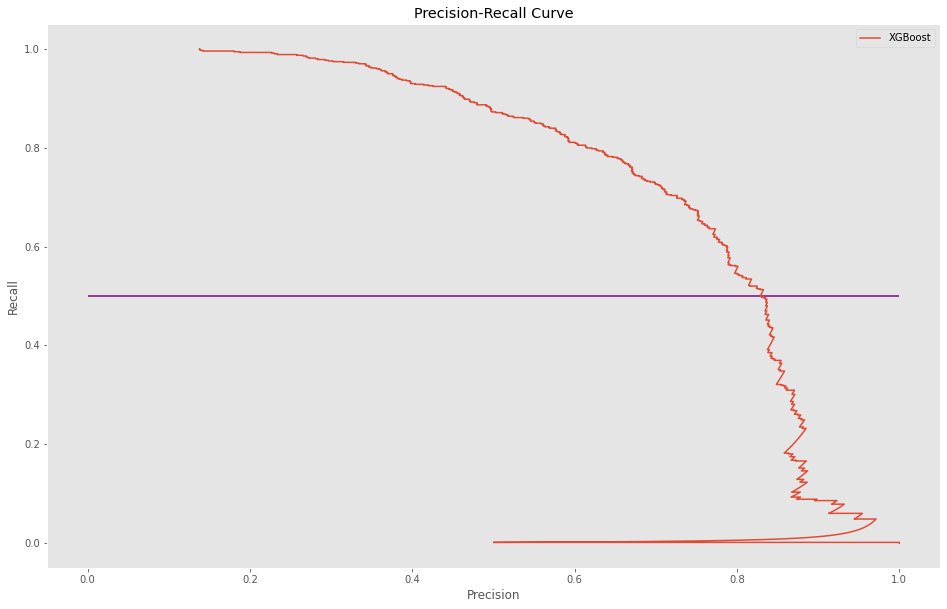

In [61]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_true=y_test, probas_pred=xgb_ros_tuned.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(precision_xgb, recall_xgb, label='XGBoost')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='purple')
ax.legend()
ax.grid();

This is exactly what we want to see in a precision-recall curve.  We can see the area under this curve is large.

##**Conclusion**

The accuracy of the XGBooost model on the oversampled data set was very good at over 89% on the test data after 5-fold randomized search cross-validation which makes me suspect that overfitting did not occur.  This number is almost identical to the average cross-validation accuracy on the training set. I created a hyperparameter tuning function to capture the best parameters for the model.  I utilized a combination of one-hot and target encoding for three categorical variables.  A balanced random forest model was attempted as well as SMOTE but the expected results did not materialize and they were not very good classifiers of customers who will purchase a term deposit.  The area under the ROC curve was 0.96 for this model. The Lazy Classifier was used to help identify XGBoost function for this project.

Feature selection was performed during exploratory data analysis where the month feature did not have an even distribution of values.  The majority of observations were in the month of May and none were observed in September.  Additionally, contact was removed from the data set as there were a large number of unknown values and there was a very small distribution of customers who were contacted on their telephones as opposed to cellular.  I did not see how this would lend any insight especially since there were fewer customers that purchased a term deposit in the telephones class. The call duration was also removed as this feature introduces bias into the model because most of the time on these calls is used for setting up the purchase and this is an implied result in this case. 

The XGBoost model has an embedded feature importance function and the results were a little surprising.  Customers that have defaulted has little importance on the model in terms of subscribing to a term deposit.  However, the average daily balance of the customer was considered to be the most important feature in this model. Usually, with most banking business problems, the balance of an account is a usually of great importance to a model.  The age of the customer and how many times the customer was contacted also had large importance as well.  Lastly, the age of the customer has importance as well. Customers who have an average yearly balance over $656 and are over the age of 60 are prime candidates to purchase a term deposit. 
     